# Imports

In [2]:
import io
import gc
import os
import sys
import cv2
import torch
import requests
import tempfile
import contextlib
import numpy as np
from PIL import Image
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import pipeline
from torchvision import transforms
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForCausalLM 
from detector_utils import adapt_mmdet_pipeline, init_detector, process_images_detector
from classes_and_palettes import (
    COCO_KPTS_COLORS,
    COCO_WHOLEBODY_KPTS_COLORS,
    GOLIATH_KPTS_COLORS,
    GOLIATH_SKELETON_INFO,
    GOLIATH_KEYPOINTS,
    GOLIATH_PALETTE, 
    GOLIATH_CLASSES
)

[2024-09-25 14:09:00,285] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ilyass/mambaforge/envs/tamp/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/home/ilyass/mambaforge/envs/tamp/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.4
 [WARNING]  using untested triton version (3.0.0), only 1.0.0 is known to be compatible


In [ ]:
# np.set_printoptions(threshold=sys.maxsize)

# Helpers

In [ ]:
"""
    SAM2 Plotting 
"""
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
        
"""
    Sapiense Foundation Models
"""
class Config:
    ASSETS_DIR = "../assets/"
    CHECKPOINTS_DIR = "../assets/checkpoints/"
    CHECKPOINTS = {
        "0.3bp": "pose/sapiens_0.3b_goliath_best_goliath_AP_575_torchscript.pt2",
        "1bp": "pose/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2",

        "0.3s": "segmentation/sapiens_0.3b_goliath_best_goliath_mIoU_7673_epoch_194_torchscript.pt2",
        "0.6s": "segmentation/sapiens_0.6b_goliath_best_goliath_mIoU_7777_epoch_178_torchscript.pt2",
        "1bs": "segmentation/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2"
    }
    DETECTION_CHECKPOINT = "../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth"
    DETECTION_CONFIG = "../assets/assets_rtmdet_m_640-8xb32_coco-person_no_nms.py"
    
class ModelManager:
    @staticmethod
    def load_model(checkpoint_name: str):
        if checkpoint_name is None:
            return None

        checkpoint_path = os.path.join(Config.CHECKPOINTS_DIR, checkpoint_name)
        model = torch.jit.load(checkpoint_path)
        model.eval()
        model.to(device)
        
        return model

    @staticmethod
    @torch.inference_mode()
    def run_model_keypoints(model, input_tensor):
        return model(input_tensor)

    @staticmethod
    @torch.inference_mode()
    def run_model_segmentation(model, input_tensor, height, width):
        output = model(input_tensor)
        output = torch.nn.functional.interpolate(output, size=(height, width), mode="bilinear", align_corners=False)
        _, preds = torch.max(output, 1)
        return preds

class ImageProcessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((1024, 768)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[123.5/255, 116.5/255, 103.5/255], 
                                 std=[58.5/255, 57.0/255, 57.5/255])
        ])
        self.detector = init_detector(
            Config.DETECTION_CONFIG, Config.DETECTION_CHECKPOINT, device='cpu'
        )
        self.detector.cfg = adapt_mmdet_pipeline(self.detector.cfg)

    def detect_persons(self, image: Image.Image):
        # Convert PIL Image to tensor
        image = np.array(image)
        image = np.expand_dims(image, axis=0)

        # Perform person detection
        bboxes_batch = process_images_detector(
            image, 
            self.detector
        )
        bboxes = self.get_person_bboxes(bboxes_batch[0])  # Get bboxes for the first (and only) image
        
        return bboxes
    
    def get_person_bboxes(self, bboxes_batch, score_thr=0.3):
        person_bboxes = []
        for bbox in bboxes_batch:
            if len(bbox) == 5:  # [x1, y1, x2, y2, score]
                if bbox[4] > score_thr:
                    person_bboxes.append(bbox)
            elif len(bbox) == 4:  # [x1, y1, x2, y2]
                person_bboxes.append(bbox + [1.0])  # Add a default score of 1.0
        return person_bboxes

    @torch.inference_mode()
    def estimate_pose(self, image: Image.Image, bboxes: List[List[float]], model_name: str, kpt_threshold: float):
        pose_model = ModelManager.load_model(Config.CHECKPOINTS[model_name])
        
        result_image = image.copy()
        all_keypoints = []  # List to store keypoints for all persons

        for bbox in bboxes:
            cropped_img = self.crop_image(result_image, bbox)
            input_tensor = self.transform(cropped_img).unsqueeze(0).to(device)
            heatmaps = ModelManager.run_model_keypoints(pose_model, input_tensor)
            keypoints = self.heatmaps_to_keypoints(heatmaps[0].cpu().numpy())
            all_keypoints.append(keypoints)  # Collect keypoints
            result_image = self.draw_keypoints(result_image, keypoints, bbox, kpt_threshold)
        
        return result_image, all_keypoints

    def process_image_keypoints(self, image: Image.Image, model_name: str, kpt_threshold: str):
        bboxes = self.detect_persons(image)
        result_image, keypoints = self.estimate_pose(image, bboxes, model_name, float(kpt_threshold))
        return result_image, keypoints

    def process_image_segmentation(self, image: Image.Image, model_name: str):
        model = ModelManager.load_model(Config.CHECKPOINTS[model_name])
        input_tensor = self.transform(image).unsqueeze(0).to("cuda")
        
        preds = ModelManager.run_model_segmentation(model, input_tensor, image.height, image.width)
        mask = preds.squeeze(0).cpu().numpy()

        # Visualize the segmentation
        blended_image = self.visualize_pred_with_overlay(image, mask)

        # Create downloadable .npy file
        npy_path = tempfile.mktemp(suffix='.npy')
        np.save(npy_path, mask)

        return blended_image, npy_path

    def crop_image(self, image, bbox):
        if len(bbox) == 4:
            x1, y1, x2, y2 = map(int, bbox)
        elif len(bbox) >= 5:
            x1, y1, x2, y2, _ = map(int, bbox[:5])
        else:
            raise ValueError(f"Unexpected bbox format: {bbox}")
        
        crop = image.crop((x1, y1, x2, y2))
        return crop

    @staticmethod
    def heatmaps_to_keypoints(heatmaps):
        num_joints = heatmaps.shape[0]  # Should be 308
        keypoints = {}
        for i, name in enumerate(GOLIATH_KEYPOINTS):
            if i < num_joints:
                heatmap = heatmaps[i]
                y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
                conf = heatmap[y, x]
                keypoints[name] = (float(x), float(y), float(conf))
        return keypoints

    @staticmethod
    def draw_keypoints(image, keypoints, bbox, kpt_threshold):
        image = np.array(image)

        # Handle both 4 and 5-element bounding boxes
        if len(bbox) == 4:
            x1, y1, x2, y2 = map(int, bbox)
        elif len(bbox) >= 5:
            x1, y1, x2, y2, _ = map(int, bbox[:5])
        else:
            raise ValueError(f"Unexpected bbox format: {bbox}")
                
        # Calculate adaptive radius and thickness based on bounding box size
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        bbox_size = np.sqrt(bbox_width * bbox_height)
        
        radius = max(1, int(bbox_size * 0.006))  # minimum 1 pixel
        thickness = max(1, int(bbox_size * 0.006))  # minimum 1 pixel
        bbox_thickness = max(1, thickness//4)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), bbox_thickness)
        
        # Draw keypoints
        for i, (name, (x, y, conf)) in enumerate(keypoints.items()):
            if conf > kpt_threshold and i < len(GOLIATH_KPTS_COLORS):
                x_coord = int(x * bbox_width / 192) + x1
                y_coord = int(y * bbox_height / 256) + y1
                color = GOLIATH_KPTS_COLORS[i]
                cv2.circle(image, (x_coord, y_coord), radius, color, -1)

        # Draw skeleton
        for _, link_info in GOLIATH_SKELETON_INFO.items():
            pt1_name, pt2_name = link_info['link']
            color = link_info['color']
            
            if pt1_name in keypoints and pt2_name in keypoints:
                pt1 = keypoints[pt1_name]
                pt2 = keypoints[pt2_name]
                if pt1[2] > kpt_threshold and pt2[2] > kpt_threshold:
                    x1_coord = int(pt1[0] * bbox_width / 192) + x1
                    y1_coord = int(pt1[1] * bbox_height / 256) + y1
                    x2_coord = int(pt2[0] * bbox_width / 192) + x1
                    y2_coord = int(pt2[1] * bbox_height / 256) + y1
                    cv2.line(image, (x1_coord, y1_coord), (x2_coord, y2_coord), color, thickness=thickness)

        return Image.fromarray(image)

    @staticmethod
    def visualize_pred_with_overlay(img, sem_seg, alpha=0.5):
        img_np = np.array(img.convert("RGB"))
        sem_seg = np.array(sem_seg)

        num_classes = len(GOLIATH_CLASSES)
        ids = np.unique(sem_seg)[::-1]
        legal_indices = ids < num_classes
        ids = ids[legal_indices]
        labels = np.array(ids, dtype=np.int64)

        colors = [GOLIATH_PALETTE[label] for label in labels]

        overlay = np.zeros((*sem_seg.shape, 3), dtype=np.uint8)

        for label, color in zip(labels, colors):
            overlay[sem_seg == label, :] = color

        blended = np.uint8(img_np * (1 - alpha) + overlay * alpha)
        return Image.fromarray(blended)

In [ ]:
"""
    Florence VLM
"""
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()

# Device Definition

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Depth Estimation

In [2]:
# # Load RGB image
# rgb_image = Image.open("./generated_images/grasp/floor/image11.png").convert('RGB')

### DepthAnythingV2

In [3]:
# # Load depth estimation pipeline
# # pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf")
# pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf")

In [4]:
# # Compute relative depth estimation
# depth_image = pipe(rgb_image)["depth"]

In [5]:
# # Plot RGB and depth side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the first image
# ax1.imshow(rgb_image)
# ax1.set_title('RGB')
# ax1.axis('off')  # Hide axes

# # Plot the second image
# ax2.imshow(depth_image)
# ax2.set_title('Depth (Relative)')
# ax2.axis('off')  # Hide axes

# # Adjust the layout and display the plot
# plt.tight_layout()
# plt.show()

# Sapiens Foundation Models

In [11]:
def clean_gpu():
    with torch.no_grad():
        torch.cuda.empty_cache()

In [12]:
image_processor = ImageProcessor()

Loads checkpoint by local backend from path: ../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth on server: atari
Done: Loaded checkpoint from ../assets/checkpoints/pose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth on server: atari


### Segmentation

In [12]:
# segmentation_image, npy_path = image_processor.process_image_segmentation(Image.fromarray(rgb_match), "1bs")
segmentation_image, npy_path = image_processor.process_image_segmentation(rgb_image, "1bs")
clean_gpu()

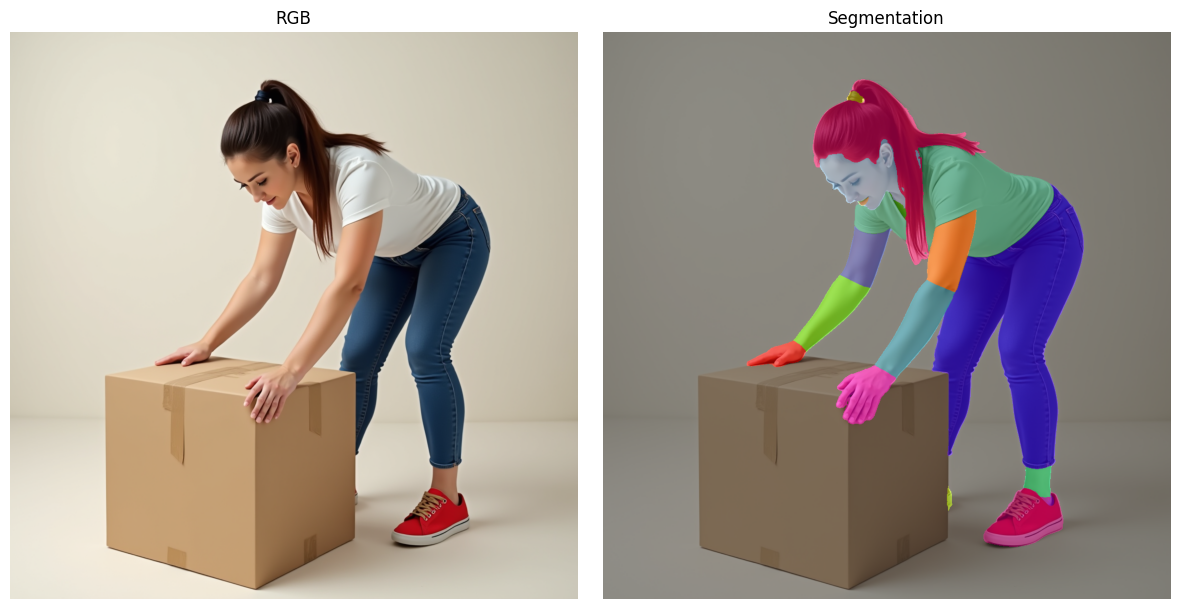

In [13]:
# Plot RGB and depth side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
ax1.imshow(rgb_image)
ax1.set_title('RGB')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(segmentation_image)
ax2.set_title('Segmentation')
ax2.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Depth + Removed Segmented Person

In [14]:
# Read mask information
mask = np.load(npy_path)

In [15]:
cv_mask = np.where(mask > 0, 255, 0)
cv_mask = np.asarray(cv_mask, dtype=np.uint8)

In [16]:
depth_without_person = cv2.inpaint(np.asarray(depth_image), cv_mask, 40, cv2.INPAINT_TELEA)

In [17]:
rgb_without_person = cv2.inpaint(np.asarray(rgb_image), cv_mask, 40, cv2.INPAINT_TELEA)

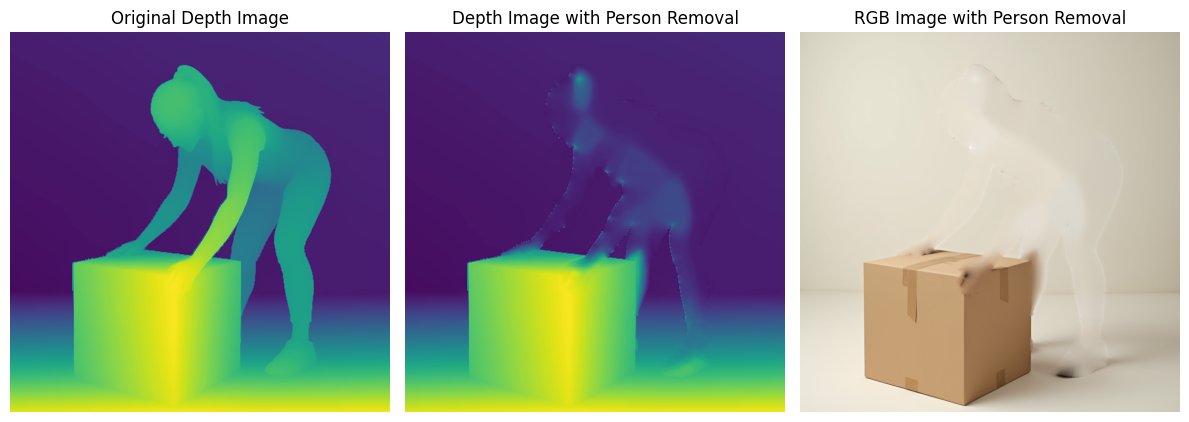

In [18]:
# Plot RGB and depth side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot the first image
ax1.imshow(depth_image)
ax1.set_title('Original Depth Image')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(depth_without_person)
ax2.set_title('Depth Image with Person Removal')
ax2.axis('off')  # Hide axes

# Plot the second image
ax3.imshow(rgb_without_person)
ax3.set_title('RGB Image with Person Removal')
ax3.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Keypoints

In [19]:
keypoints_image, keypoints = image_processor.process_image_keypoints(rgb_image, "1bp", 0.3)
clean_gpu()

/home/ilyass/.local/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


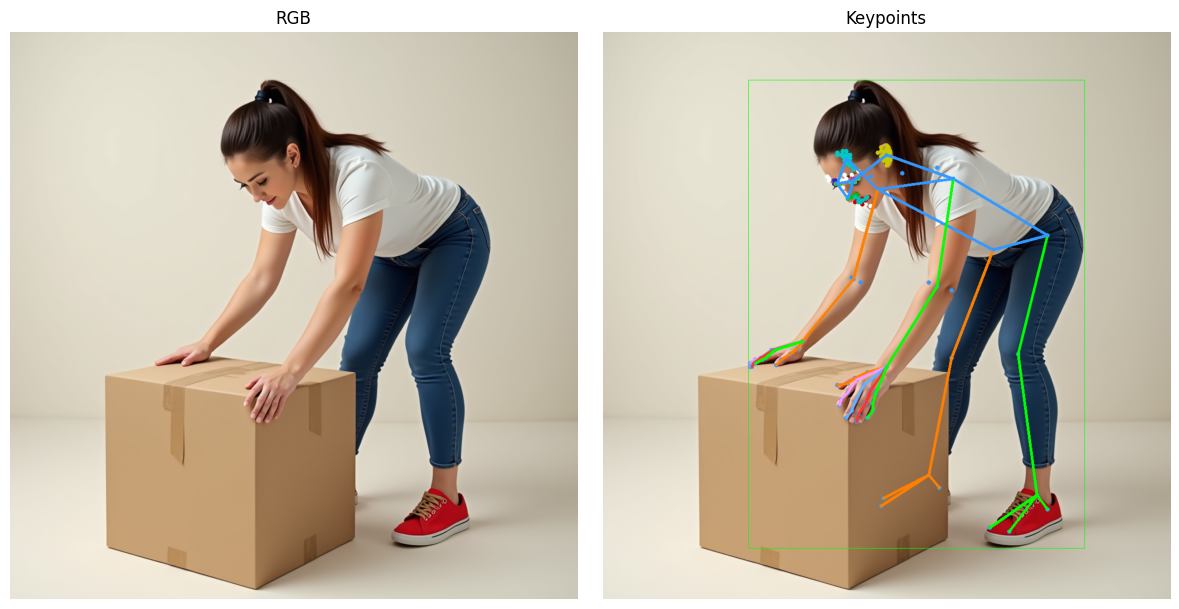

In [20]:
# Plot RGB and depth side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
ax1.imshow(rgb_image)
ax1.set_title('RGB')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(keypoints_image)
ax2.set_title('Keypoints')
ax2.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Retrieval System

#### Matching Photos

In [22]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import os

# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = Image.open(img_path).resize((224, 224))
    img_array = img_to_array(img)
    img_array = img_array[:,:,:3]
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

def find_similar_images(reference_img_path, image_folder, top_n=3):
    # Extract features for reference image
    reference_features = extract_features(reference_img_path)
    
    # Extract features for all images in the folder
    image_features = []
    image_paths = []
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, img_name)
            features = extract_features(img_path)
            image_features.append(features)
            image_paths.append(img_path)
    
    # Calculate similarities
    similarities = cosine_similarity([reference_features], image_features)[0]
    
    # Sort and get top N similar images
    top_indices = similarities.argsort()[-top_n:][::-1]
    top_similar = [(image_paths[i], similarities[i]) for i in top_indices]
    
    return top_similar

# Usage example
reference_image = '/home/ilyass/reference.png'
# reference_image = './generated_images/grasp/floor/image0.png'
image_folder = './generated_images/grasp/floor'
# image_folder = '/home/ilyass/Pictures/Screenshots'
similar_images = find_similar_images(reference_image, image_folder)

for img_path, similarity in similar_images:
    print(f"Image: {img_path}, Similarity: {similarity}")

clean_gpu()

del model
import gc

gc.collect()
torch.cuda.empty_cache()

I0000 00:00:1727178496.128964   56232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727178496.138071   56232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727178496.138291   56232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727178496.140238   56232 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1727178499.083489   59540 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: ./generated_images/grasp/floor/image11.png, Similarity: 0.37855494022369385
Image: ./generated_images/grasp/floor/image13.png, Similarity: 0.3712812066078186
Image: ./generated_images/grasp/floor/image1.png, Similarity: 0.34929579496383667


#### Mask Extraction

In [8]:
# Load Florence and SAM2 models
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to("cuda")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

In [9]:
def extract_mask(rgb_image):
    task_prompt = '<OPEN_VOCABULARY_DETECTION>'
    results = run_example(task_prompt, rgb_image, text_input="a box")

    bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

    with torch.inference_mode(), torch.autocast("cpu", dtype=torch.bfloat16):
        
        predictor.set_image(rgb_image)
    
        input_point_x = (bbox_results['bboxes'][0][0] + bbox_results['bboxes'][0][2])/2
        input_point_y = (bbox_results['bboxes'][0][1] + bbox_results['bboxes'][0][3])/2
        input_point = np.array([[input_point_x, input_point_y]])
        input_label = np.array([1])
    
        masks, scores, logits = predictor.predict(point_coords=input_point,
                                                  point_labels=input_label,
                                                  multimask_output=False)

        clean_gpu()

    return masks, scores, logits, bbox_results

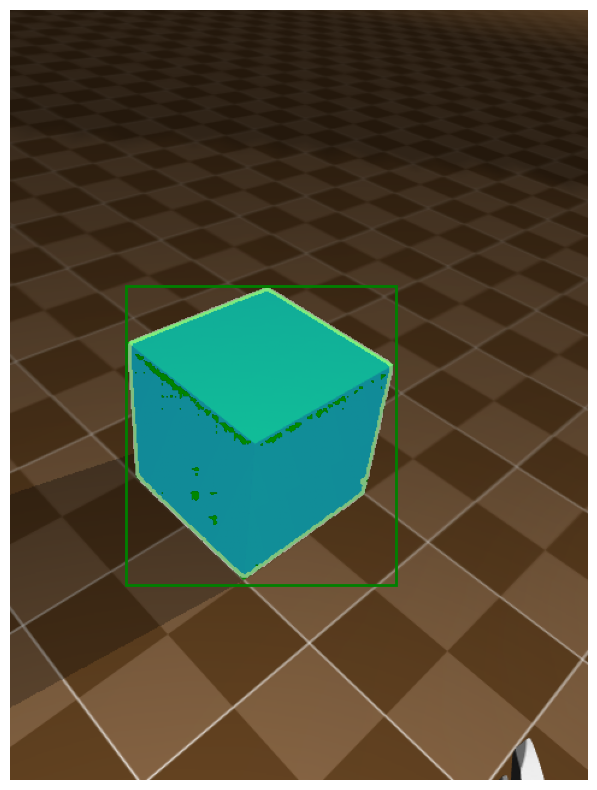

In [13]:
# Reference Image
input_point = None
input_label = None

ref_reg_image = Image.open("/home/ilyass/reference.png")
masks_ref, scores_ref, logits_ref, bbox_results_ref = extract_mask(ref_reg_image)
show_masks(ref_reg_image, masks_ref, scores_ref, box_coords=bbox_results_ref['bboxes'][0], point_coords=input_point, input_labels=input_label)

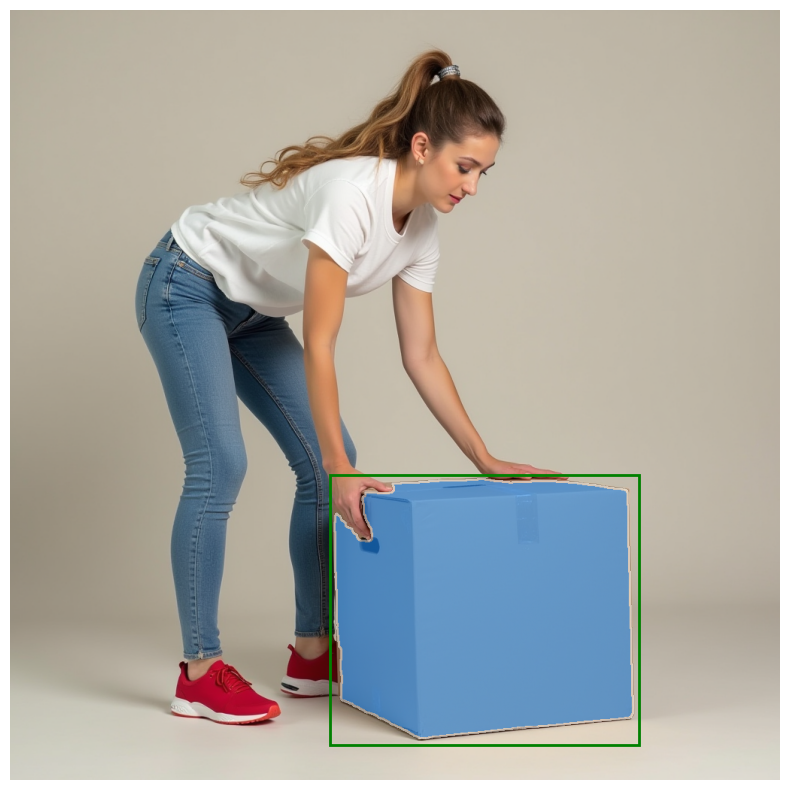

In [14]:
# Reference Image
input_point = None
input_label = None

match_rgb_image = Image.open("./generated_images/grasp/floor/image13.png")
masks_match, scores_match, logits_match, bbox_results_match = extract_mask(match_rgb_image)
show_masks(match_rgb_image, masks_match, scores_match, box_coords=bbox_results_match['bboxes'][0], point_coords=input_point, input_labels=input_label)

In [15]:
clean_gpu()

In [16]:
del model, processor, predictor
import gc

gc.collect()
torch.cuda.empty_cache()

#### Matching Keypoints (RGB Approach)

In [39]:
# # Find depth box around matching image
# depth_image = pipe(match_rgb_image)["depth"]

row = int(bbox_results_match['bboxes'][0][1])
row_height = int(bbox_results_match['bboxes'][0][3] - bbox_results_match['bboxes'][0][1])

col = int(bbox_results_match['bboxes'][0][0])
col_width = int(bbox_results_match['bboxes'][0][2] - bbox_results_match['bboxes'][0][0])

rgb_match = np.asarray(match_rgb_image)[row:row + row_height, col:col + col_width]

# # Find depth box around reference image
# depth_image = pipe(ref_reg_image)["depth"]

row = int(bbox_results_ref['bboxes'][0][1])
row_height = int(bbox_results_ref['bboxes'][0][3] - bbox_results_ref['bboxes'][0][1])

col = int(bbox_results_ref['bboxes'][0][0])
col_width = int(bbox_results_ref['bboxes'][0][2] - bbox_results_ref['bboxes'][0][0])

rgb_ref = np.asarray(ref_reg_image)[row:row + row_height, col:col + col_width]

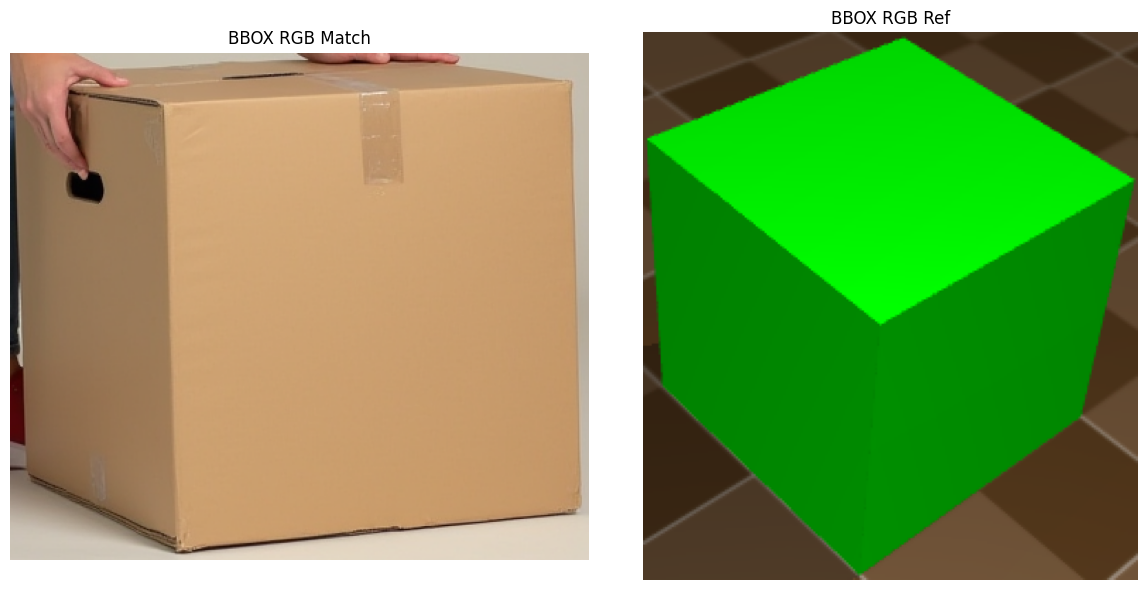

In [40]:
# Plot RGB and depth side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
ax1.imshow(rgb_match)
ax1.set_title('BBOX RGB Match')
ax1.axis('off')  # Hide axes

# Plot the second image
ax2.imshow(rgb_ref)
ax2.set_title('BBOX RGB Ref')
ax2.axis('off')  # Hide axes

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

(< cv2.DMatch 0x782803dbcbf0>, < cv2.DMatch 0x782803069270>, < cv2.DMatch 0x782967368c30>)


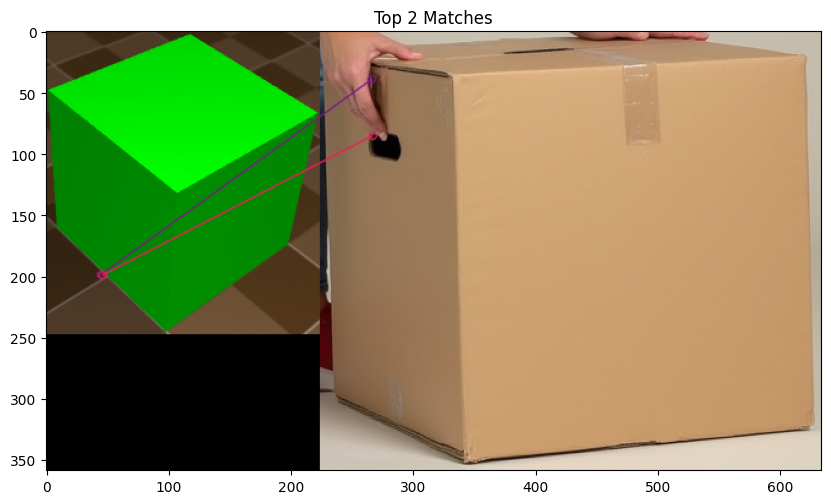

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the two images (grayscale for simplicity)
img1 = np.asarray(rgb_ref)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# img1 = img1[:, :, ::-1].copy()

img2 = np.asarray(rgb_match)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# img2 = img2[:, :, ::-1].copy()

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors in the masked areas
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Initialize the brute force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)
print(matches)

# Sort matches based on the distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top N matches
N = 2  # Number of top matches to display
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title(f"Top {N} Matches")
plt.show()

#### Matching Keypoints (Metric3D Approach)

In [81]:
from metric3d.mono.utils.do_test import transform_test_data_scalecano, get_prediction

ModuleNotFoundError: No module named 'mono'

In [ ]:
def predict_depth_normal(img, model_selection="vit-small", fx=1000.0, fy=1000.0, state_cache={}):
    if model_selection == "vit-small":
        model = model_small
        cfg = cfg_small
    elif model_selection == "vit-large":
        model = model_large
        cfg = cfg_large
    else:
        return None, None, None, None, state_cache, "Not implemented model."
    
    if img is None:
        return None, None, None, None, state_cache, "Please upload an image and wait for the upload to complete."

    cv_image = np.array(img) 
    img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    intrinsic = [fx, fy, img.shape[1]/2, img.shape[0]/2]
    rgb_input, cam_models_stacks, pad, label_scale_factor = transform_test_data_scalecano(img, intrinsic, cfg.data_basic)

    with torch.no_grad():
        pred_depth, pred_depth_scale, scale, output, confidence = get_prediction(
                    model = model,
                    input = rgb_input,
                    cam_model = cam_models_stacks,
                    pad_info = pad,
                    scale_info = label_scale_factor,
                    gt_depth = None,
                    normalize_scale = cfg.data_basic.depth_range[1],
                    ori_shape=[img.shape[0], img.shape[1]],
                )

        pred_normal = output['normal_out_list'][0][:, :3, :, :] 
        H, W = pred_normal.shape[2:]
        pred_normal = pred_normal[:, :, pad[0]:H-pad[1], pad[2]:W-pad[3]]

    pred_depth = pred_depth.squeeze().cpu().numpy()
    pred_depth[pred_depth<0] = 0
    pred_color = gray_to_colormap(pred_depth)

    pred_normal = torch.nn.functional.interpolate(pred_normal, [img.shape[0], img.shape[1]], mode='bilinear').squeeze()
    pred_normal = pred_normal.permute(1,2,0)
    pred_color_normal = vis_surface_normal(pred_normal)
    pred_normal = pred_normal.cpu().numpy()
    
    # Storing depth and normal map in state for potential 3D reconstruction
    state_cache['depth'] = pred_depth
    state_cache['normal'] = pred_normal
    state_cache['img'] = img
    state_cache['intrinsic'] = intrinsic
    state_cache['confidence'] = confidence 

    # save depth and normal map to .npy file
    if 'save_dir' not in state_cache:
        cache_id = np.random.randint(0, 100000000000)
        while osp.exists(f'recon_cache/{cache_id:08d}'):
            cache_id = np.random.randint(0, 100000000000)
        state_cache['save_dir'] = f'recon_cache/{cache_id:08d}'
        os.makedirs(state_cache['save_dir'], exist_ok=True)
    depth_file = f"{state_cache['save_dir']}/depth.npy"
    normal_file = f"{state_cache['save_dir']}/normal.npy"
    np.save(depth_file, pred_depth)
    np.save(normal_file, pred_normal)

    ##formatted = (output * 255 / np.max(output)).astype('uint8')
    img = Image.fromarray(pred_color)
    img_normal = Image.fromarray(pred_color_normal)
    return img, depth_file, img_normal, normal_file, state_cache, "Success!"
